<a href="https://colab.research.google.com/github/tylerlum/Tray_Image_Classifier_A/blob/master/TensorFlow_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import random

%matplotlib inline
np.random.seed(1)

In [0]:
##################################### Small Helper Functions #####################################
def download_files():
  """
  Use google_drive_downloader to download HiRes and LoRes data
  """
  !pip install googledrivedownloader
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1smbsz8AJ-VGhKbtr7NTvAVzTI3auI_C4',
                                      dest_path='/content/tray-data/HiRes.7z')
  gdd.download_file_from_google_drive(file_id='1wZ-AHv4yx_lXGeaqKzbTNuap6mpESyEq',
                                      dest_path='/content/tray-data/LoRes.7z')

  # Extract.7z file
  %cd /content/tray-data
  !7z x /content/tray-data/HiRes.7z 
  !7z x /content/tray-data/LoRes.7z 
  
def get_one_hot_encoding(ordered_class_names):
  """
  Create a dictionary that maps class names to integers from 0 upwards. 
  Requires ordered list
  """
  one_hot_encoding = {}
  i = 0
  for class_name in ordered_class_names:
    one_hot_encoding[class_name] = i
    i = i + 1
  return one_hot_encoding

def get_distinct_random_ints(num_ints, low, high):
  """
  Returns list of length num_ints
  Each value is a number n such that low <= n <= high
  Each value is distinct
  """
  retVal = []
  for i in range(0, num_ints):
    rand_int = random.randint(low, high)
    while rand_int in retVal:
      rand_int = random.randint(low, high)
    retVal.append(rand_int)
  return retVal

def one_hot_encode(class_name, num_classes, one_hot_encoding):
  retVal = np.zeros((num_classes, 1))
  retVal[one_hot_encoding[class_name]] = 1
  return retVal

##################################### Medium Helper Functions #####################################
def load_full_dataset(path_to_imgs):
  """
  Creates a dictionary that maps class names to numpy arrays representing images
  Requires a full path to the images
  """
  full_dataset = {}
  i = 0
  for directory in os.listdir(path_to_imgs):
    x_data = []
    directory_path = path_to_imgs + '/' + directory
    for png in os.listdir(directory_path):
      # Get image and convert to numpy array
      png_path = directory_path + '/' + png
      im = cv2.imread(png_path)
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      x_data.append(im)
      
    ## Add key value pair to full_dataset
    full_dataset[str(directory)] = x_data
    
  return full_dataset

def get_dataset(full_dataset, desired_classes, pics_per_class):
  """
  full_dataset = dictionary from classes to image data
  desired_classes = list of desired classes
  pics_per_class = integer number of pictures for each class
  S"""
  # One hot encoding setup
  classes = [class_name for class_name in full_dataset]
  classes.sort()
  one_hot_encoding = get_one_hot_encoding(classes)
  
  # Initialize return values
  X = None
  Y = None
  
  num_classes = len(desired_classes)
  
  for class_name in desired_classes:
    
    indices = get_distinct_random_ints(pics_per_class, 0, len(full_dataset[class_name]) - 1)

    # Add images from this class
    for index in indices:
      
      im = full_dataset[class_name][index]
      # Add to training set
      # Initialize array
      if X is None:
        X = np.array([im])
        label = one_hot_encode(class_name, num_classes, one_hot_encoding)
        Y = np.array([label])
      # Append to array
      else:
        X = np.append(X, [im], axis=0)
        label = one_hot_encode(class_name, num_classes, one_hot_encoding)
        Y = np.append(Y, [label], axis=0)

  Y = Y[:, :, 0].T
  return X, Y
           
def load_train_and_test_dataset(path_to_imgs, desired_classes=None, pics_per_class=50):
  # Handle default case
  if desired_classes is None:
    desired_classes = os.listdir(path_to_imgs)
  
  # Load full dataset
  full_dataset = load_full_dataset(path_to_imgs)
  
  # Get training and testing data from full_dataset
  X_train, Y_train = get_dataset(full_dataset, desired_classes=desired_classes, pics_per_class=pics_per_class)
  X_test, Y_test = get_dataset(full_dataset, desired_classes=desired_classes, pics_per_class=pics_per_class // 2)  # Note may have some matching with training data
  return X_train, Y_train, X_test, Y_test

In [0]:
download_files()

In [0]:
path_to_imgs = '/content/tray-data/data_LoRes/single'
X_train, Y_train, X_test, Y_test = load_train_and_test_dataset(path_to_imgs)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1150, 64, 64, 3)
(23, 1150)
(575, 64, 64, 3)
(23, 575)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


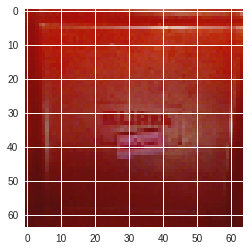

In [9]:
index = 100
plt.imshow(X_train[index])
print(Y_train[:, index])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


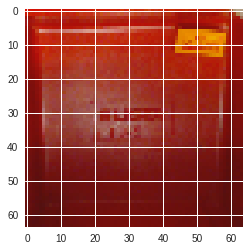

In [10]:
index = 190
plt.imshow(X_test[index])
print(Y_test[:, index])

In [0]:
# Reshape the training and test examples 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = X_train_flatten/255.
test_x = X_test_flatten/255.

train_y = Y_train
test_y = Y_test

In [12]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 1150)
test_x's shape: (12288, 575)
train_y's shape: (23, 1150)
test_y's shape: (23, 575)


In [0]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    ### END CODE HERE ###
    
    return X, Y

In [0]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_px, n_classes):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [20, n_px]
                        b1 : [20, 1]
                        W2 : [12, 20]
                        b2 : [12, 1]
                        W3 : [n_classes, 12]
                        b3 : [n_classes, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [20, n_px], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [20, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 20], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_classes, 12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [n_classes, 1], initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [0]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    ### END CODE HERE ###
    
    return Z3

In [0]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [0]:
def random_mini_batches(X_train, Y_train, minibatch_size, seed):
  """
  Return a minibatch of size minibatch_size
  Gets random training data indices from X_train and Y_train
  """
  random.seed(seed)
  retVal = []
  (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
  (n_y, m) = Y_train.shape 

  num_minibatches = m // minibatch_size - 2
  visited = []
  
  for minibatch in range(0, num_minibatches):
    # Initialize arrays
    x = np.zeros((n_x, minibatch_size))
    y = np.zeros((n_y, minibatch_size))
    for i in range(0, minibatch_size):
      # Find unvisited index
      index = -1
      while index < 0:
        index = random.randint(0, X_train.shape[1] - 1)
        if index in visited:
          index = -1
      visited.append(index)
      
      # Add to array
      x[:, i] = X_train[:, index]
      y[:, i] = Y_train[:, index]
    retVal.append((x, y))
      
  return retVal

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.00001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost

    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters(n_x, n_y)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        saver = tf.train.Saver()
        saver.save(sess, './' + 'model.checkpoint')
        print ("Model saved")
        return parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 2.956586
Cost after epoch 100: 2.386968
Cost after epoch 200: 1.974625
Cost after epoch 300: 1.576446
Cost after epoch 400: 1.243965
Cost after epoch 500: 0.933666
Cost after epoch 600: 0.725693
Cost after epoch 700: 0.571833
Cost after epoch 800: 0.474865
Cost after epoch 900: 0.411114
Cost after epoch 1000: 0.339405
Cost after epoch 1100: 0.306311
Cost after epoch 1200: 0.262684
Cost after epoch 1300: 0.232929
Cost after epoch 1400: 0.202608
Cost after epoch 1500: 0.180963
C

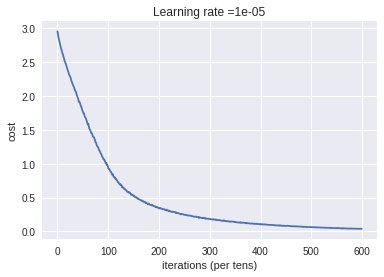

Parameters have been trained!
Train Accuracy: 0.9956522
Test Accuracy: 0.89913046
Model saved


In [19]:
parameters = model(train_x, train_y, test_x, test_y, num_epochs = 3000)